# Constant

In [3]:
from pathlib import Path


ROOT_DIR = Path("vocab")
ROOT_DIR.mkdir(parents=True, exist_ok=True)

COMMON_VOCAB_DIR = ROOT_DIR / "common_english_words"
COMMON_VOCAB_DIR.mkdir(parents=True, exist_ok=True)

MODEL_LIST = [
    "01-ai/Yi-34B-Chat",
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-13b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    "codellama/CodeLlama-34b-Instruct-hf",
    "lmsys/vicuna-13b-v1.5",
    "Nexusflow/Starling-LM-7B-beta",
]

# Load Model Vocabulary

In [4]:
import json
from pathlib import Path
from transformers import AutoTokenizer

ROOT_DIR = Path("vocab")
ROOT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_LIST = [
    "01-ai/Yi-34B-Chat",
    "mistralai/Mistral-7B-v0.1",
    "mistralai/Mixtral-8x7B-Instruct-v0.1",
    "meta-llama/Llama-2-7b-chat-hf",
    "meta-llama/Llama-2-13b-chat-hf",
    "meta-llama/Llama-2-70b-chat-hf",
    "codellama/CodeLlama-34b-Instruct-hf",
    "lmsys/vicuna-13b-v1.5",
    "Nexusflow/Starling-LM-7B-beta",
]


def generate_save_path(model_path: str, root_dir: Path) -> Path:
    _, model_name = model_path.split("/")
    return root_dir / f"{model_name}.json"


def save_vocab(model_path: str, save_path: Path) -> None:
    if save_path.exists():
        print(f" Skip `{model_path}` because it already exists.")
        return

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        vocab = tokenizer.get_vocab()
        save_path.write_text(json.dumps(vocab, ensure_ascii=False, indent=4))
        print(f"Successfully saved vocab for '{model_path}' to {save_path}")
    except Exception as e:
        print(f"Failed to save vocab for '{model_path}': {e}")


def main() -> None:
    for model_path in MODEL_LIST:
        save_path = generate_save_path(model_path, ROOT_DIR)
        save_vocab(model_path, save_path)


if __name__ == "__main__":
    main()

 Skip `01-ai/Yi-34B-Chat` because it already exists.
 Skip `mistralai/Mistral-7B-v0.1` because it already exists.
 Skip `mistralai/Mixtral-8x7B-Instruct-v0.1` because it already exists.
 Skip `meta-llama/Llama-2-7b-chat-hf` because it already exists.
 Skip `meta-llama/Llama-2-13b-chat-hf` because it already exists.
 Skip `meta-llama/Llama-2-70b-chat-hf` because it already exists.
 Skip `codellama/CodeLlama-34b-Instruct-hf` because it already exists.
 Skip `lmsys/vicuna-13b-v1.5` because it already exists.
 Skip `Nexusflow/Starling-LM-7B-beta` because it already exists.


# Load Vocab

In [5]:
import json
from pathlib import Path
from collections import OrderedDict


class Vocab(OrderedDict):
    def __init__(self, model_vocab_paths: dict[str, Path], common_vocab_dir: Path):
        super().__init__()
        self.load_vocabs(model_vocab_paths, common_vocab_dir)

    def load_vocabs(
        self, model_vocab_paths: dict[str, Path], common_vocab_dir: Path
    ) -> None:
        # Load model vocab
        self.update(
            {
                model_name: self.load_vocab(path, is_json=True)
                for model_name, path in model_vocab_paths.items()
            }
        )

        # * Assume all common vocab files are txt files under common_vocab_dir
        common_vocab_paths = common_vocab_dir.glob("*.txt")
        self.update({path.stem: self.load_vocab(path) for path in common_vocab_paths})

    @staticmethod
    def load_vocab(path: Path, is_json: bool = False) -> set[str]:
        with path.open("r", encoding="utf-8") as file:
            if is_json:
                return set(json.load(file))
            return {line.strip() for line in file if line.strip()}


def create_model_vocab_paths(model_list: list[str], root_dir: Path) -> dict[str, Path]:
    return {
        Path(model).parts[-1]: root_dir / f"{Path(model).parts[-1]}.json"
        for model in model_list
    }


model_vocab_paths = create_model_vocab_paths(MODEL_LIST, ROOT_DIR)
vocab = Vocab(model_vocab_paths, COMMON_VOCAB_DIR)

In [28]:
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt


def plot_vocab_venn(
    vocab: dict[str, set[str]], model_names: list[str], common_vocab_key: str
) -> None:
    common_vocab = vocab.get(common_vocab_key)
    if not common_vocab:
        raise ValueError(f"Common vocabulary '{common_vocab_key}' not found.")

    model_vocabs = [
        vocab.get(name) & common_vocab for name in model_names if name in vocab
    ]
    if not model_vocabs:
        raise ValueError("Model names provided do not exist in the vocab dictionary.")

    if len(model_vocabs) == 1:
        subsets = (
            len(model_vocabs[0] - common_vocab),
            len(common_vocab - model_vocabs[0]),
            len(model_vocabs[0] & common_vocab),
        )
        venn_func = venn2
        set_labels = (model_names[0], common_vocab_key)
    elif len(model_vocabs) == 2:
        subsets = {
            "100": len(model_vocabs[0] - model_vocabs[1] - common_vocab),
            "010": len(model_vocabs[1] - model_vocabs[0] - common_vocab),
            "001": len(common_vocab - model_vocabs[0] - model_vocabs[1]),
            "110": len(model_vocabs[0] & model_vocabs[1] - common_vocab),
            "101": len(model_vocabs[0] & common_vocab - model_vocabs[1]),
            "011": len(model_vocabs[1] & common_vocab - model_vocabs[0]),
            "111": len(model_vocabs[0] & model_vocabs[1] & common_vocab),
        }
        venn_func = venn3
        set_labels = (model_names[0], model_names[1], common_vocab_key)
    else:
        raise ValueError(
            "Only one or two model names are supported for the Venn diagram. "
            f"There are {len(model_names)} in the model list provided. model_names: {model_names}."
        )

    plt.figure(figsize=(8, 8))
    venn_func(subsets=subsets, set_labels=set_labels)
    plt.title("Venn Diagram of Vocabulary Sets with Common Vocabulary")
    plt.show()

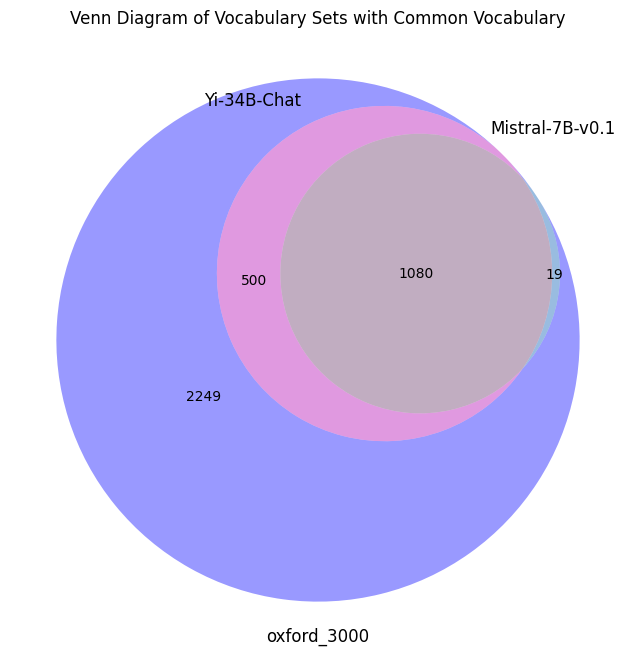

In [31]:
plot_vocab_venn(
    vocab,
    model_names=["Yi-34B-Chat", "Mistral-7B-v0.1"],
    # model_names=["Yi-34B-Chat"],
    common_vocab_key="oxford_3000",
)

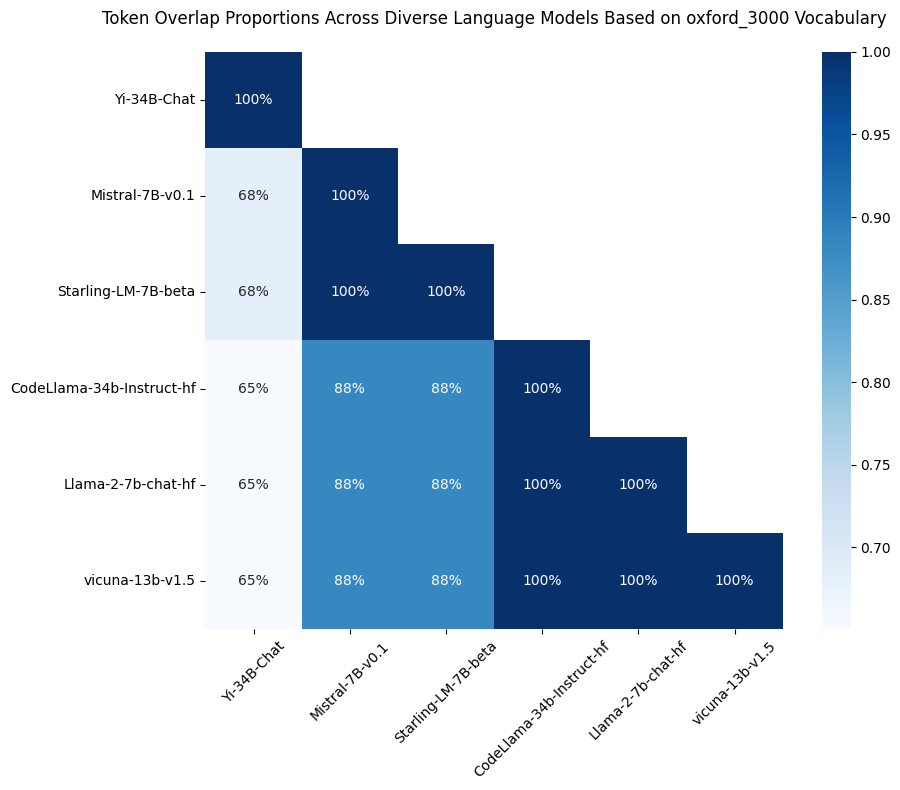

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_overlap_heatmap(
    vocab: dict, model_names: list[str], common_vocab_key: str
) -> None:
    """
    Generates a lower-triangle heatmap showing the proportion of shared tokens
    between the vocabularies of different language models, relative to the vocabulary
    size of the model represented by each row.

    Args:
        vocab: A dictionary where keys are model names and values are sets of tokens.
        model_names: A list of model names for which to calculate and display the overlaps.
        common_vocab_key: The key in the vocab dictionary representing the common vocabulary.

    """
    common_vocab = vocab[common_vocab_key]
    intersections = {name: vocab[name] & common_vocab for name in model_names}
    ratios = pd.DataFrame(
        [
            [
                (
                    len(intersections[row] & intersections[col])
                    / len(intersections[col])
                    if i >= j
                    else None
                )  # Fill the upper triangle with None
                for j, col in enumerate(model_names)
            ]
            for i, row in enumerate(model_names)
        ],
        index=model_names,
        columns=model_names,
    )

    mask = pd.isnull(ratios)
    plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
    heatmap = sns.heatmap(
        ratios, annot=True, fmt=".0%", cmap="Blues", mask=mask, square=True
    )
    heatmap.set_title(
        f"Token Overlap Proportions Across Diverse Language Models Based on {common_vocab_key} Vocabulary",
        pad=20,
    )
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_overlap_heatmap(
    vocab,
    model_names=[
        "Yi-34B-Chat",
        "Mistral-7B-v0.1",
        "Starling-LM-7B-beta",
        "CodeLlama-34b-Instruct-hf",
        "Llama-2-7b-chat-hf",
        "vicuna-13b-v1.5",
    ],
    common_vocab_key="oxford_3000",
)